In [17]:
import pandas as pd 
import seaborn as sns
#from ydata_profiling import ProfileReport
#import sweetviz as sv
#import dtale
import numpy as np
import statistics
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt

from scipy import stats # библиотека для расчетов
import sweetviz  as sv
from sklearn.preprocessing import LabelEncoder
hotels = pd.read_csv('C:\\Users\\Admin\\Desktop\\Data_pandas/hotels.csv')
hotels_copy = hotels.copy()
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
object_columns

['hotel_address',
 'review_date',
 'hotel_name',
 'reviewer_nationality',
 'negative_review',
 'positive_review',
 'tags',
 'days_since_review']

## Преоброзование строковых столбцов в числовые и Создание новых признаков

Работа  с колонкой hotel_address. Преобразуем в BinaryEncoder для избавления от строкового признака. Результатом стало 10 колонок с адресами

In [18]:
from category_encoders import BinaryEncoder

# Предположим, что у вас есть DataFrame df с колонкой 'hotel_address'
encoder = BinaryEncoder(cols=['hotel_address'])

# Обучаем энкодер и преобразуем данные
hotels = encoder.fit_transform(hotels)




Работа  с колонкой review_date. Преобразуем в формат дата для избавления от строкового признака.

In [19]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y', errors='coerce')

Работа  с колонкой review_date. Преобразуем в BinaryEncoder для избавления от строкового признака.

In [20]:
from category_encoders import BinaryEncoder

# Предположим, что у вас есть DataFrame df с колонкой 'hotel_address'
encoder = BinaryEncoder(cols=['hotel_name'])

# Обучаем энкодер и преобразуем данные
hotels = encoder.fit_transform(hotels)


Работа  с колонкой reviewer_nationality. Преобразуем в OrdinalEncoder для избавления от строкового признака.

In [21]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Создаем экземпляр класса OrdinalEncoder
encoder = OrdinalEncoder()

# Преобразуем столбец reviewer_nationality
encoded_values = encoder.fit_transform(hotels[['reviewer_nationality']])

# Добавляем закодированные значения обратно в dataframe
hotels['reviewer_nationality_encoded'] = encoded_values.astype(int).ravel() # .ravel() используется для преобразования массива в одномерный вид

hotels = hotels.drop(columns= 'reviewer_nationality')


Работа  с колонкой negative_review, positive_review. Преобразуем в значение 1 или 0, где 1 в negative_review говорит о наличие отрицательного отзыва, а в positive_review 1 о его отсуттсвие. 

In [22]:
# Функция для проверки наличия негативных слов
def contains_negative_word(review):
    negative_words = {'no', 'No', 'нет', 'Нет', 'Не'}
    words = review.lower().split()  # Преобразование текста в нижний регистр и разделение на слова
    return 1 if any(word in negative_words for word in words) else 0
# Применение функции ко всему столбцу
hotels['contains_negative'] = hotels['negative_review'].apply(contains_negative_word)

hotels = hotels.drop(columns=['negative_review'])
def contains_positive_word(reviews):
    positive_words ={'no', 'No', 'нет', 'Нет', 'Не'}
    words = reviews.lower().split()  # Преобразование текста в нижний регистр и разделение на слова
    return 0 if any(word in positive_words for word in words) else 1
# Применение функции ко всему столбцу
hotels['contains_positive'] = hotels['positive_review'].apply(contains_positive_word)
hotels = hotels.drop(columns=['positive_review'])

Работа  с колонкой tags. Преобразуем в OrdinalEncoder для избавления от строкового признака. ravel для изменения массива с 2-мерного на 1-мерный.

In [23]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Предположим, что hotels уже загружены и содержат нужный столбец 'tags'

# Создаем экземпляр класса OrdinalEncoder
encoder = OrdinalEncoder()

# Применяем fit_transform к нужному столбцу
hotels['tags_encoded'] = encoder.fit_transform(hotels[['tags']]).ravel()

# Добавляем закодированный столбец обратно в DataFrame
hotels['all_tags'] = hotels_copy['tags'].explode() 

hotels = hotels.drop(columns = 'tags')


Работа  с колонкой days_since_review. Преобразуем в int для избавления от строкового признака. Буду искать зависимость в количестве дней

In [24]:
hotels['days_since_review'] = hotels['days_since_review'].str.split(' ', expand=True)[0].astype(int)

Работа  с колонкой lat и lng. в зависимости от координат буду пытаться вычислить страну и регион

from geopy.geocoders import Nominatim
import time

Функция для определения страны и региона по координатам
def reverse_geocode(lat, lng):
    geolocator = Nominatim(user_agent="my_app")
    time.sleep(1)  # Пауза в 1 секунда между запросами
    location = geolocator.reverse((lat, lng))
    address = location.raw["address"] if location else {}
    country = address.get("country", "")
    region = address.get("state", "")
    return country, region

Удалим строки с NaN в координатах
hotels = hotels.dropna(subset=["lat", "lng"])

Применение функции к каждой строке DataFrame
hotels['Country'], hotels['Region'] = zip(*hotels.apply(lambda row: reverse_geocode(row['lat'], row['lng']), axis=1))

Печать обновленного DataFrame
print(hotels)

Не хватает мощьеости и времени поэтому эту часть программы пропущу. Мог бы изменить на lat lng, но я предполагаю что координаты не особо пересекаются между собой, исключение страны и регионы, но к сожалению данные долго обрабатываются 

In [25]:
hotels = hotels.drop(columns = ['lat', 'lng'])

## Очистка от пропущенных значений

Проверим на дубликаты  и если они есть уберем их так как информационной ценности он нам не даёт. А также проверим на пропуски "Nan", их поменяем на '0'

Количество дубликатов: 311
Размер таблицы после удаления дубликатов: (386492, 36)


<Axes: >

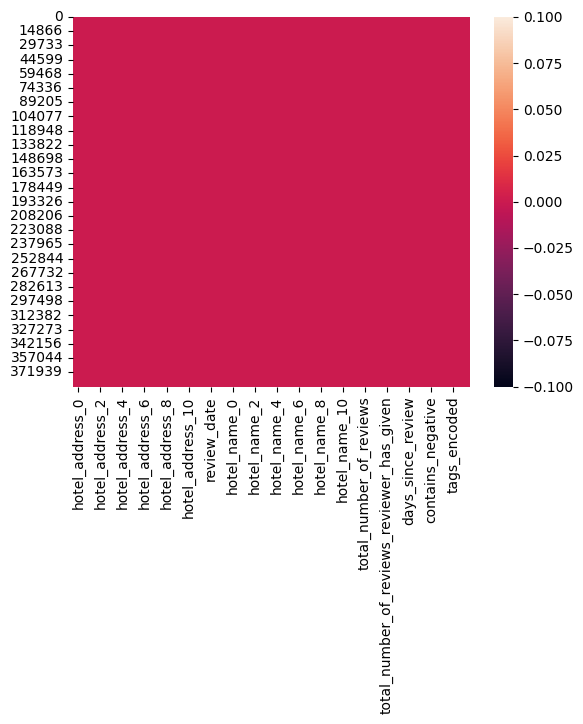

In [26]:
print('Количество дубликатов: {}'.format(hotels[hotels.duplicated()].shape[0]))

# Удаляем дубликаты:
hotels = hotels.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(hotels.shape))

# Теперь заполним пропуски этим значением
hotels = hotels.fillna('unknown')
sns.heatmap(hotels.isnull())  # Создаёт тепловые карты (heatmaps) пропущенных значений (NaN) в датасете.

## Выполнение задания из DS

In [27]:
hotels_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [28]:
s = hotels_copy['hotel_name'].unique() # 4.2
i = len(s)
i


1492

In [29]:
mask = sorted(hotels['review_date'])  # 4.3
print(mask[1],mask[-1])

2015-08-04 00:00:00 2017-08-03 00:00:00


In [30]:
hotels_copy.tags = hotels_copy.tags.apply(lambda x: x[3:-3].split(" ', ' "))  # 4.4

tags = list(hotels_copy.tags.explode().value_counts())
len(tags)

2368

In [31]:
# s = hotels_copy.tags.mode() # 4.5

In [32]:

# Распаковка тегов (развернём список тегов в отдельные строки)   # 4.6
all_tags = hotels_copy['tags'].explode()    

# Отфильтруем только те теги, которые содержат информацию о числе ночей
night_tags = all_tags[all_tags.str.contains('\\d+ night')]

# Подсчитаем частоту каждого уникального числа ночей
duration_count = night_tags.value_counts()

# Определим самый популярный вариант
most_common_duration = duration_count.idxmax()

print(f"Путешественники чаще всего останавливаются на {most_common_duration}.")

Путешественники чаще всего останавливаются на Stayed 1 night.


## Преобразование признаков

hotel_address, review_date, average_score, hotel_name, reviewer_nationality, negative_review, review_total_negative_word_counts, positive_review, review_total_positive_word_counts, reviewer_score, tags, additional_number_of_scoring, (lat lng) - удалены.
Столбцы в которых не требуется стандартизация так как данные представлены в виде баллов(10 - max) или даже удалены, а также представленные в оптимальных границах 

требует стандартизации
* review_total_positive_word_counts - общее количество слов в положительном отзыве.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв;
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
 

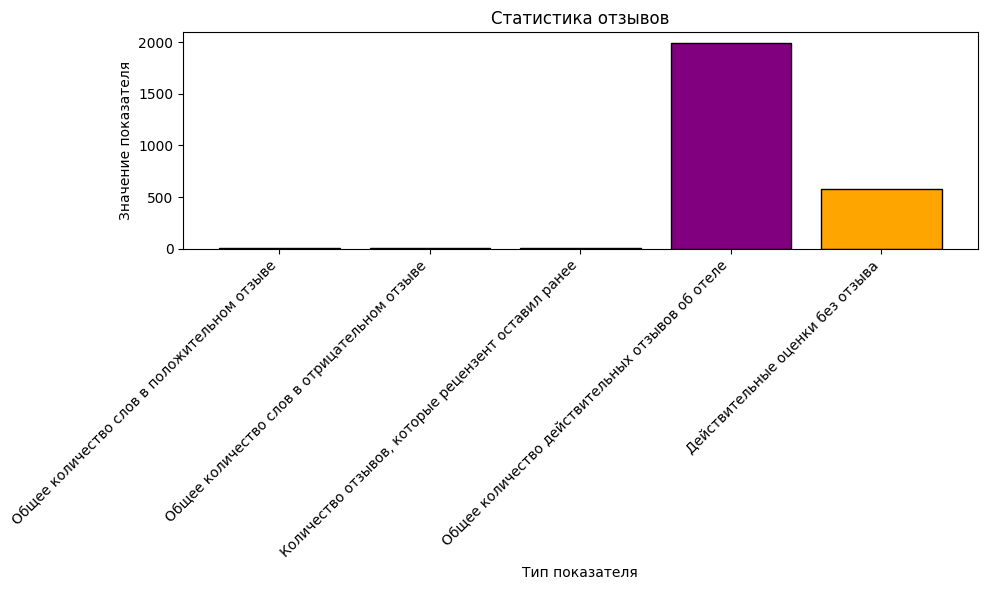

In [36]:
import matplotlib.pyplot as plt

# Исходные данные
counts = [
    hotels['review_total_positive_word_counts'].iloc[0],  # Значение первого элемента в столбце
    hotels['review_total_negative_word_counts'].iloc[0],
    hotels['total_number_of_reviews_reviewer_has_given'].iloc[0],
    hotels['total_number_of_reviews'].iloc[0],
    hotels['additional_number_of_scoring'].iloc[0]
]

# Метрики (названия полей)
metrics = [
    'Общее количество слов в положительном отзыве',
    'Общее количество слов в отрицательном отзыве',
    'Количество отзывов, которые рецензент оставил ранее',
    'Общее количество действительных отзывов об отеле',
    'Действительные оценки без отзыва'
]

# Создание гистограммы
plt.figure(figsize=(10, 6))  # Размер окна
plt.bar(metrics, counts, color=['green', 'red', 'blue', 'purple', 'orange'], edgecolor='black')

# Оформление графика
plt.title("Статистика отзывов")
plt.xlabel("Тип показателя")
plt.ylabel("Значение показателя")
plt.xticks(rotation=45, ha="right")  # Наклоняем метки
plt.tight_layout()  # Оптимизация размещения элементов

# Отображаем график
plt.show()

Видно, что данные представленны в разных диапахонах из-за чего сложно воспринимать данные.

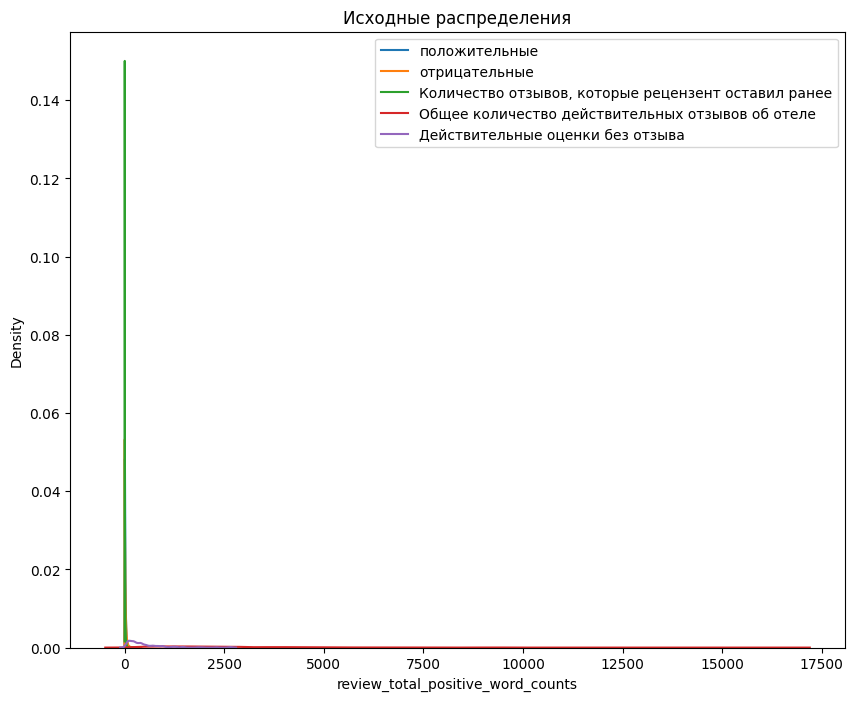

In [41]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(hotels_copy['review_total_positive_word_counts'], ax=ax1, label ='положительные')
sns.kdeplot(hotels_copy['review_total_negative_word_counts'], ax=ax1, label ='отрицательные')
sns.kdeplot(hotels_copy['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='Количество отзывов, которые рецензент оставил ранее')
sns.kdeplot(hotels_copy['total_number_of_reviews'], ax=ax1, label ='Общее количество действительных отзывов об отеле')
sns.kdeplot(hotels_copy['additional_number_of_scoring'], ax=ax1, label ='Действительные оценки без отзыва')
plt.legend()

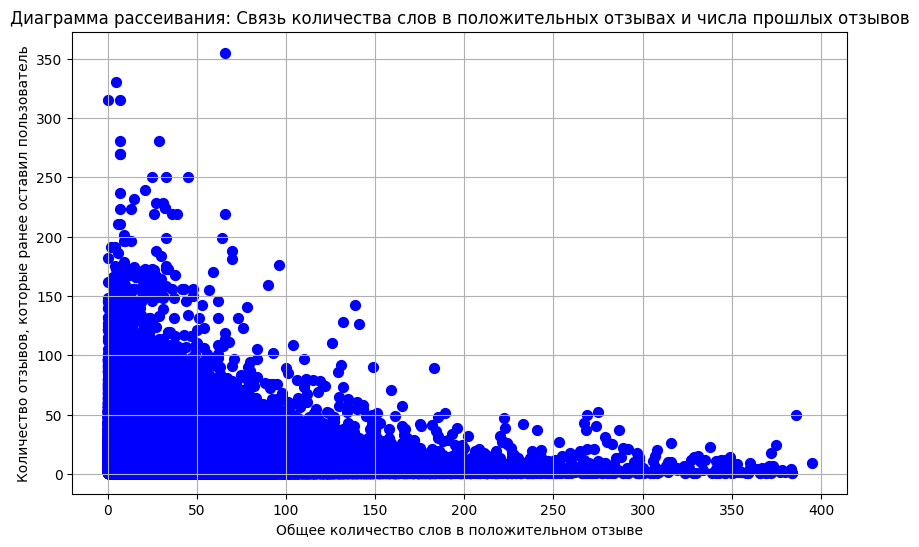

In [38]:
# Диаграмма рассеивания
plt.figure(figsize=(10, 6))

# Строим scatter plot
plt.scatter(
    x=hotels['review_total_positive_word_counts'],  # X координата (слова в положительном отзыве)
    y=hotels['total_number_of_reviews_reviewer_has_given'],  # Y координата (число прошлых отзывов)
    s=50,  # Размер точек
    c='b',  # Цвет точек
    marker='o'  # Форма маркера
)

# Заголовок и подписи осей
plt.title("Диаграмма рассеивания: Связь количества слов в положительных отзывах и числа прошлых отзывов")
plt.xlabel("Общее количество слов в положительном отзыве")
plt.ylabel("Количество отзывов, которые ранее оставил пользователь")

# Добавляем сетку
plt.grid(True)

# Показываем график
plt.show()

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Мин-макс масштабирование
scaler_minmax = MinMaxScaler()
scaled_data_minmax = scaler_minmax.fit_transform(hotels_copy[['review_total_positive_word_counts',
                                                              'review_total_negative_word_counts',
                                                              'total_number_of_reviews_reviewer_has_given',
                                                              'total_number_of_reviews',
                                                              'additional_number_of_scoring']])

# Преобразование обратно в DataFrame
df_scaled_minmax = pd.DataFrame(scaled_data_minmax, columns=[
    'review_total_positive_word_counts',
    'review_total_negative_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'total_number_of_reviews',
    'additional_number_of_scoring'
])

# Выведем первые записи
print(df_scaled_minmax.head())



   review_total_positive_word_counts  review_total_negative_word_counts  \
0                           0.010127                           0.007353   
1                           0.005063                           0.007353   
2                           0.000000                           0.014706   
3                           0.027848                           0.000000   
4                           0.050633                           0.009804   

   total_number_of_reviews_reviewer_has_given  total_number_of_reviews  \
0                                    0.016949                 0.117339   
1                                    0.036723                 0.079269   
2                                    0.036723                 0.021832   
3                                    0.019774                 0.033921   
4                                    0.025424                 0.453660   

   additional_number_of_scoring  
0                      0.216337  
1                      0.111153  
2 

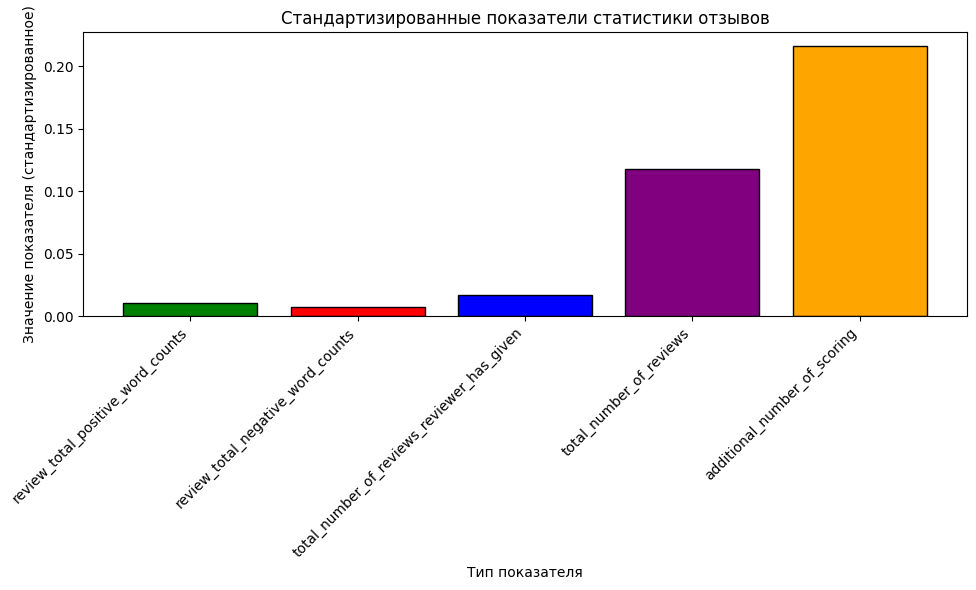

In [54]:
# Выберите одну строку данных для примера (например, первую)
row_to_plot = df_scaled_minmax.iloc[0].to_dict()

# Метрики (названия полей)
metrics = row_to_plot.keys()

# График
plt.figure(figsize=(10, 6))
plt.bar(metrics, row_to_plot.values(), color=['green', 'red', 'blue', 'purple', 'orange'], edgecolor='black')

# Оформление графика
plt.title("Стандартизированные показатели статистики отзывов")
plt.xlabel("Тип показателя")
plt.ylabel("Значение показателя (стандартизированное)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Отображаем график
plt.show()

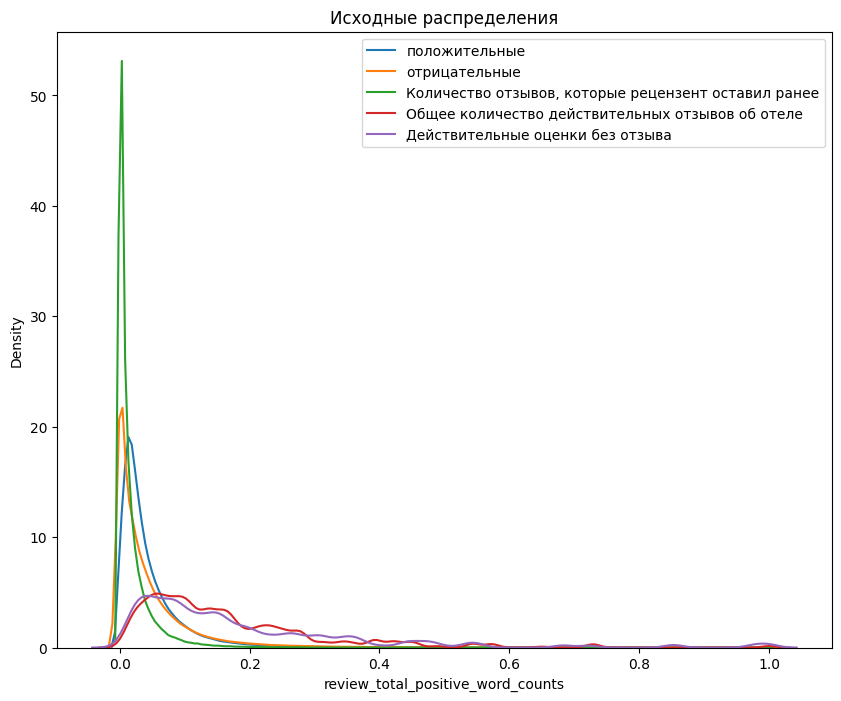

In [ ]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df_scaled_minmax['review_total_positive_word_counts'], ax=ax1, label ='положительные')
sns.kdeplot(df_scaled_minmax['review_total_negative_word_counts'], ax=ax1, label ='отрицательные')
sns.kdeplot(df_scaled_minmax['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='Количество отзывов, которые рецензент оставил ранее')
sns.kdeplot(df_scaled_minmax['total_number_of_reviews'], ax=ax1, label ='Общее количество действительных отзывов об отеле')
sns.kdeplot(df_scaled_minmax['additional_number_of_scoring'], ax=ax1, label ='Действительные оценки без отзыва')
plt.legend()

Изменения пошли нам напользу, теперь остается только присоелинить работу к основной таблице удалив предыдущие  

In [58]:
# Замещаем старое содержимое нормализованными данными
hotels_copy.update(df_scaled_minmax)

# Или можем вручную установить отдельные столбцы:
hotels_copy['review_total_positive_word_counts'] = df_scaled_minmax['review_total_positive_word_counts']
hotels_copy['review_total_negative_word_counts'] = df_scaled_minmax['review_total_negative_word_counts']
hotels_copy['total_number_of_reviews_reviewer_has_given'] = df_scaled_minmax['total_number_of_reviews_reviewer_has_given']
hotels_copy['total_number_of_reviews'] = df_scaled_minmax['total_number_of_reviews']
hotels_copy['additional_number_of_scoring'] = df_scaled_minmax['additional_number_of_scoring']

# Проверяем результат
print(hotels_copy.head())

C:\Users\Admin\AppData\Local\Temp\ipykernel_9896\3708758438.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21633719 0.11115256 0.01156285 ... 0.17008579 0.13577023 0.08243193]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hotels_copy.update(df_scaled_minmax)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9896\3708758438.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00735294 0.00735294 0.01470588 ... 0.02941176 0.         0.04901961]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hotels_copy.update(df_scaled_minmax)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9896\3708758438.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11733927 0.07926866 0.02183196 ... 0.16286762 0

                                       hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                      0.216337   2/19/2016            8.4   
1                      0.111153   1/12/2017            8.3   
2                      0.011563  10/18/2016            8.9   
3                      0.012309   9/22/2015            7.5   
4                      0.340545    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Par

C:\Users\Admin\AppData\Local\Temp\ipykernel_9896\3708758438.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01012658 0.00506329 0.         ... 0.02278481 0.01518987 0.05063291]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hotels_copy.update(df_scaled_minmax)
C:\Users\Admin\AppData\Local\Temp\ipykernel_9896\3708758438.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01694915 0.03672316 0.03672316 ... 0.05649718 0.07627119 0.00282486]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  hotels_copy.update(df_scaled_minmax)


### Нам осталось только провести Тест ANOVA и удалить данные мультиколлинеарности, проверить через MAPE нашу работу. Для себя сделать sns.pairplot

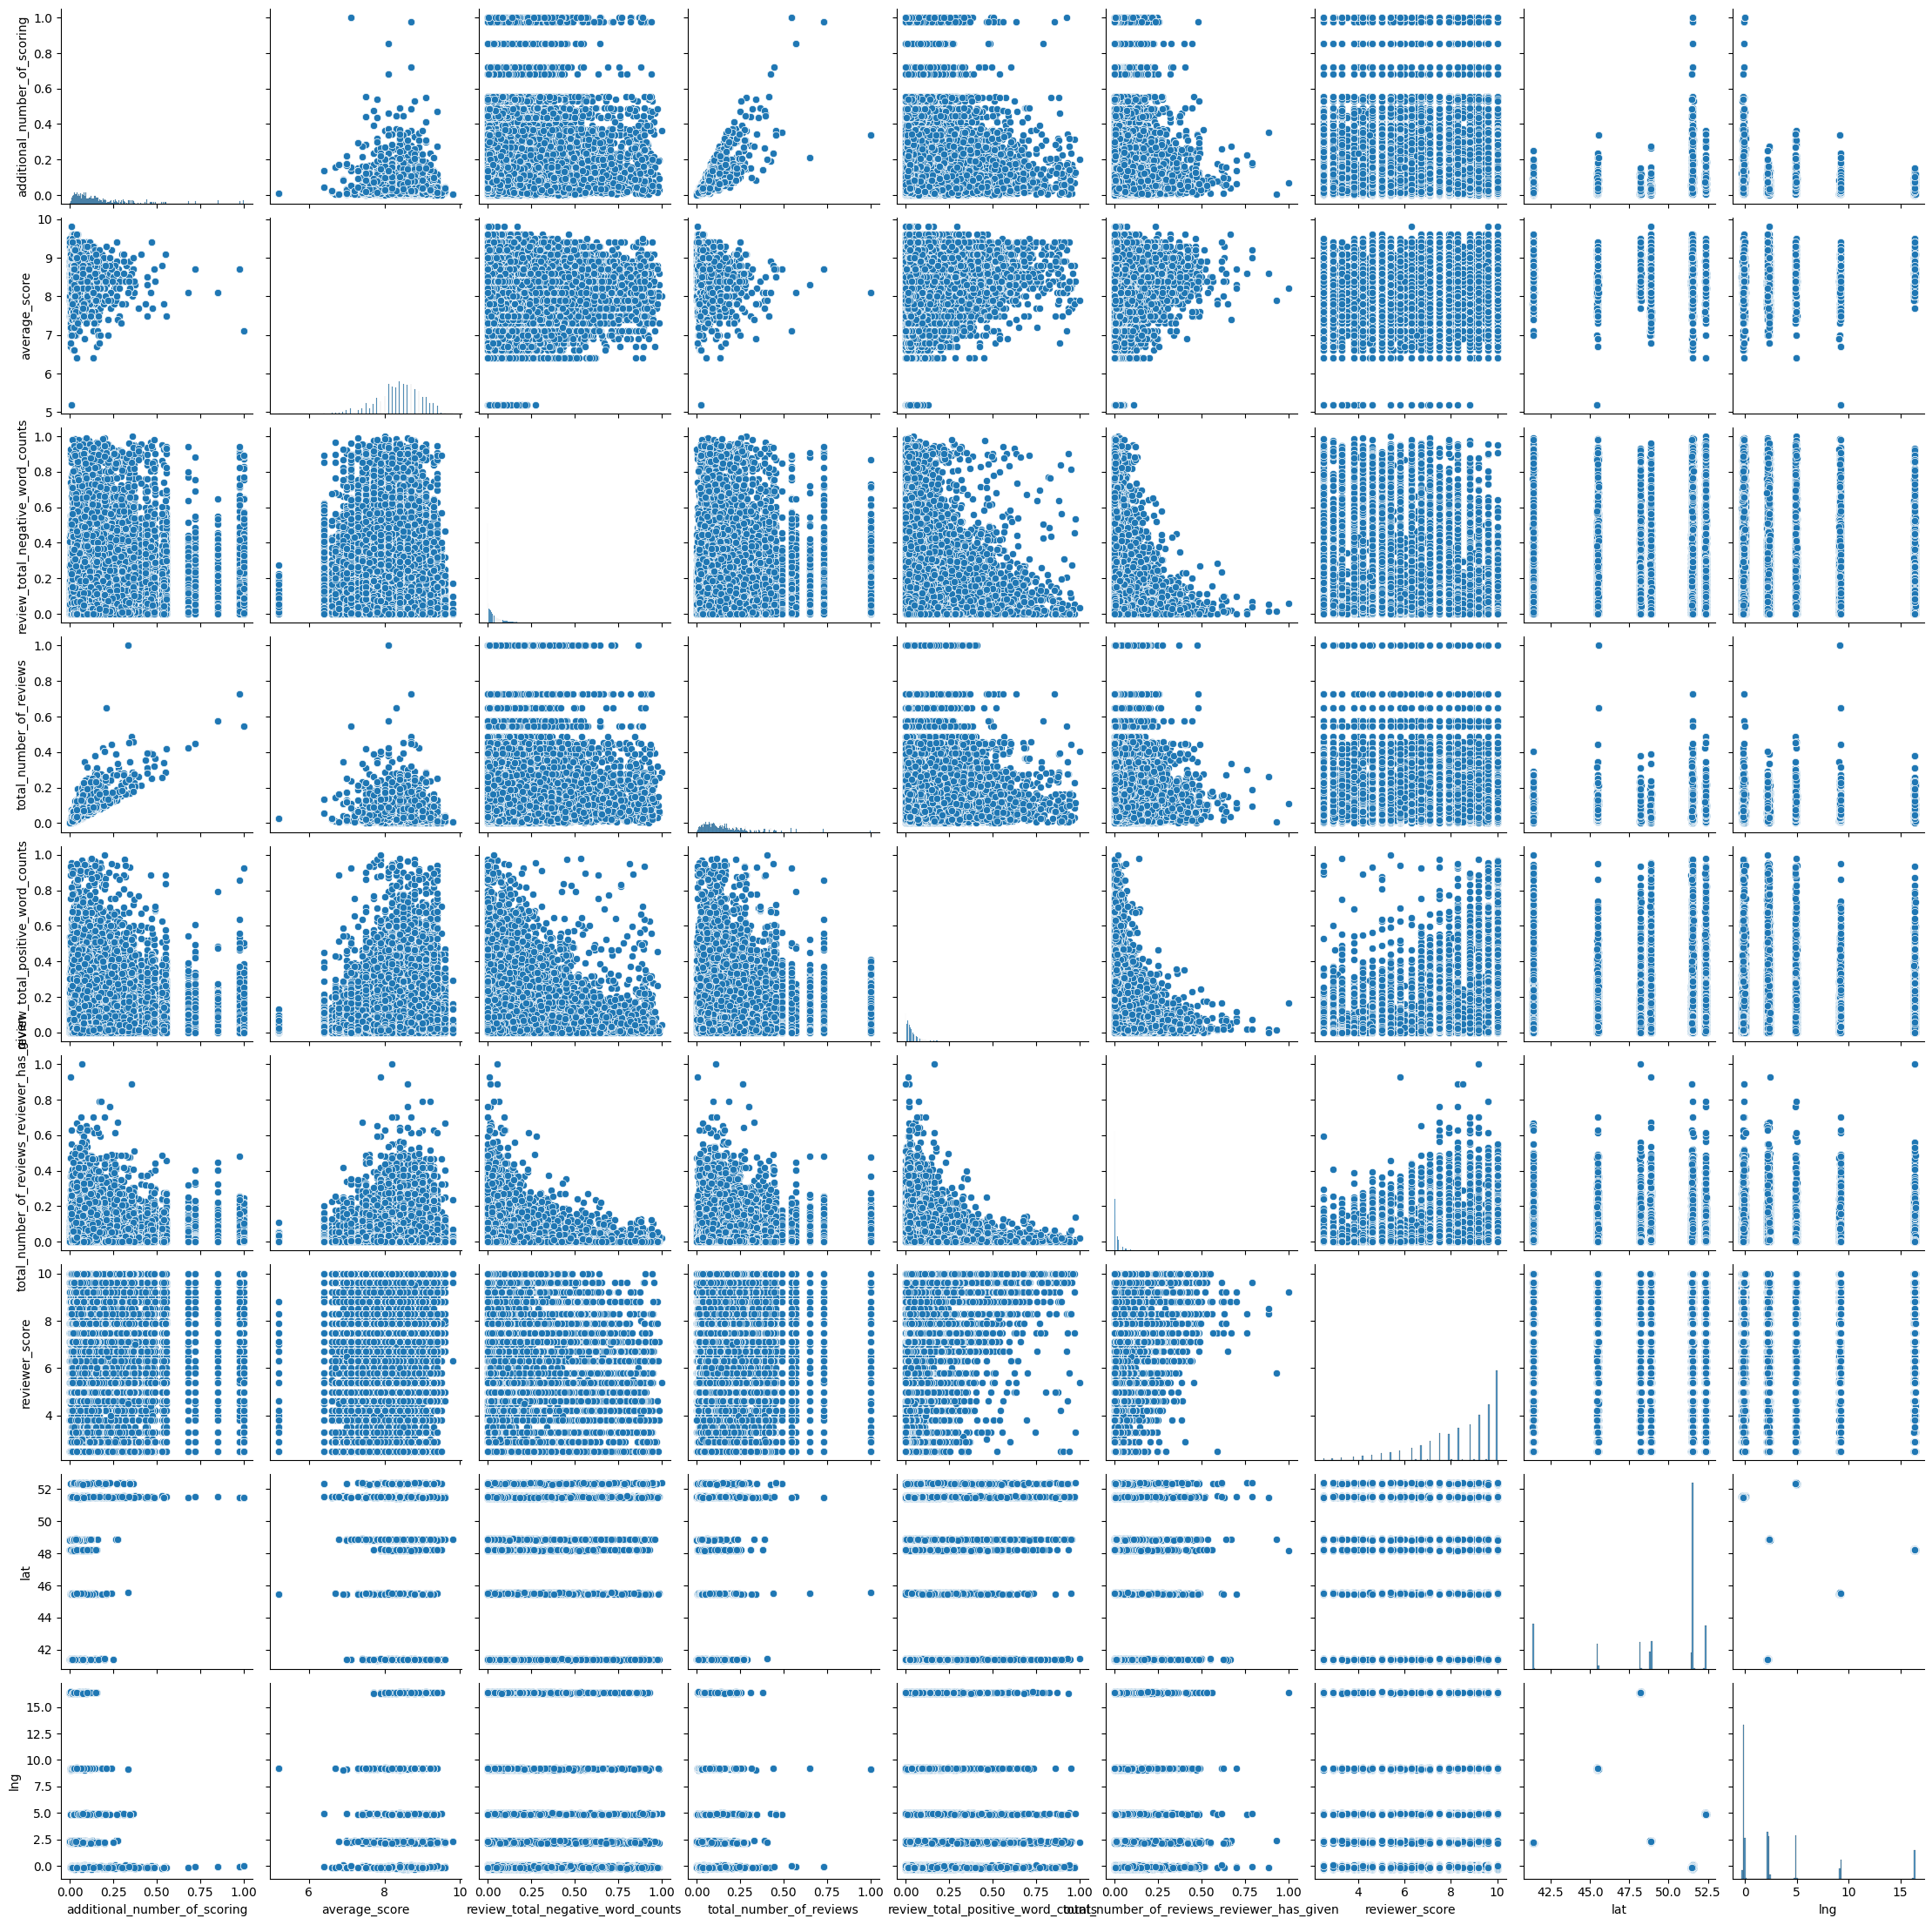

In [59]:
sns.pairplot(hotels_copy)  # target_column — ваше целевое свойство
plt.show()

                                            additional_number_of_scoring  \
additional_number_of_scoring                                    1.000000   
average_score                                                  -0.088560   
review_total_negative_word_counts                               0.033980   
total_number_of_reviews                                         0.677044   
review_total_positive_word_counts                              -0.038175   
total_number_of_reviews_reviewer_has_given                     -0.074536   
reviewer_score                                                 -0.034891   
lat                                                             0.261463   
lng                                                            -0.253489   

                                            average_score  \
additional_number_of_scoring                    -0.088560   
average_score                                    1.000000   
review_total_negative_word_counts               -0.11212

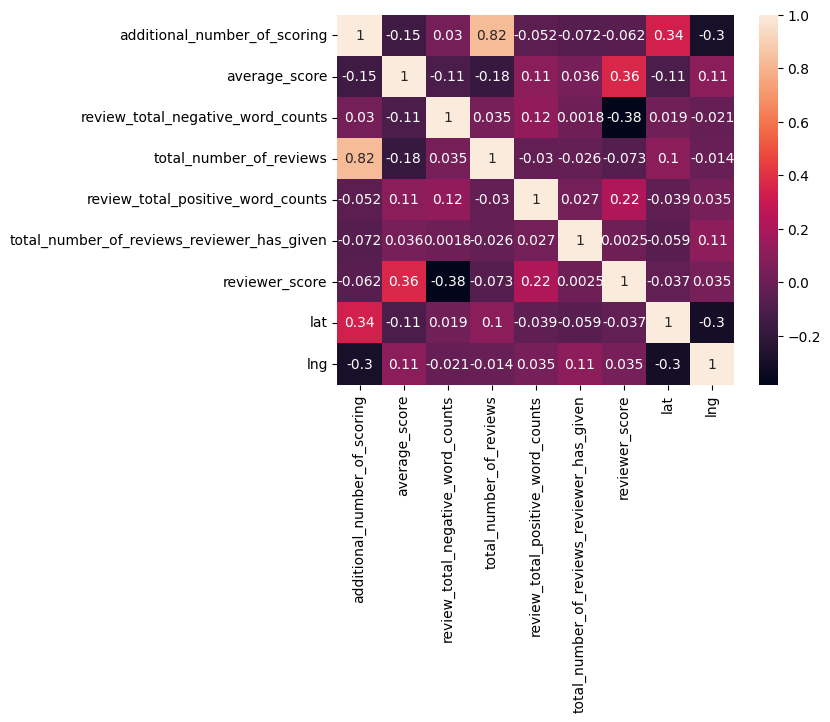

In [64]:
import seaborn as sns
heart_r1 = round(hotels_copy,2)
# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(hotels_copy.corr(numeric_only=True), annot=True)
i_kendall = hotels_copy.corr(numeric_only=True, method='kendall')
i_spearman = hotels_copy.corr(numeric_only=True, method='spearman')
i_pearson = hotels_copy.corr(numeric_only=True, method='pearson')
print(i_kendall, i_pearson, i_spearman)

Коэффициенты корреляции варьируются от -1 до 1, где:

- Значения ближе к 1 указывают на сильную положительную корреляцию.
- Значения ближе к -1 указывают на сильную отрицательную корреляцию.
- Значения около 0 указывают на отсутствие корреляции.
______________________________________________
* r > 0,01 ≤ 0,29 — слабая положительная связь; нет
* r > 0,30 ≤ 0,69 — умеренная положительная связь; да
* r > 0,70 ≤ 1,00 — сильная положительная связь; нет
* r > -0,01 ≤ -0,29 — слабая отрицательная связь; нет
* r > -0,30 ≤ -0,69 — умеренная отрицательная связь; да 
* r > -0,70 ≤ -1,00 — сильная отрицательная связь. нет

Вывод.  Для построения модели можно использовать следующие переменные:
- review_total_negative_word_counts
- review_total_positive_word_counts
- total_number_of_reviews или total_number_of_reviews_reviewer_has_given (выбрать одну из них)

К удалению представленны следующие методы 

In [65]:
hotels_copy = hotels_copy.drop(columns=['total_number_of_reviews'])

## Обработка ИИ

In [67]:
# Отбираем столбцы типа object
obj_cols = hotels_copy.select_dtypes(include=['object'])

# Заполняем пропуски в столбцах типа object значением 'unknown'
obj_cols_filled = obj_cols.fillna('unknown')

# Объединяем обратно с остальными столбцами
other_cols = hotels_copy.select_dtypes(exclude=['object'])  # Исправлено: убраны лишние квадратные скобки
df = pd.concat([other_cols, obj_cols_filled], axis=1)

In [68]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels_copy.columns if hotels_copy[s].dtypes == 'object']
hotels_copy.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
hotels_copy = hotels_copy.fillna(0)

In [69]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_copy.drop(['reviewer_score'], axis = 1)  
y = hotels_copy['reviewer_score'] 

In [70]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [71]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [72]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [73]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1411740984025005
